# Citation

Much of the code and examples are copied/modified from 

> Blueprints for Text Analytics Using Python by Jens Albrecht, Sidharth Ramachandran, and Christian Winkler (O'Reilly, 2021), 978-1-492-07408-3.
>

- https://github.com/blueprints-for-text-analytics-python/blueprints-text
- https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch08/Topic_Modeling_Clustering.ipynb

---

# Setup

In [1]:
cd ../..

/Users/shanekercheval/repos/nlp-template


In [2]:
%run "source/config/notebook_settings.py"

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
from source.library.utilities import Timer, get_logger
from source.library.text_analysis import count_tokens, tf_idf, get_context_from_keyword, count_keywords, count_keywords_by, impurity

In [14]:
with Timer("Loading Data"):
    path = 'artifacts/data/processed/un-general-debates-blueprint.pkl'
    speeches = pd.read_pickle(path)
    
    path = 'artifacts/data/processed/un-general-debates-paragraphs.pkl'
    paragraphs = pd.read_pickle(path)

Started: Loading Data
Finished (4.69 seconds)


---

# Exploratory Data Analysis

This section provides a basic exploration of the text and dataset.

## Dataset Summary

### Numeric Summary

In [15]:
hlp.pandas.numeric_summary(speeches)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
session,"7,507",0,0.0%,0,0.0%,49.6,12.9,0.3,-0.2,-1.1,25,31.0,39.0,51.0,61.0,67.0,70
year,"7,507",0,0.0%,0,0.0%,"1,994.6",12.9,0.0,-0.2,-1.1,"1,970","1,976.0","1,984.0","1,996.0","2,006.0","2,012.0","2,015"
text_length,"7,507",0,0.0%,0,0.0%,"17,967.3","7,860.0",0.4,1.1,1.8,"2,362","9,553.8","12,077.0","16,424.0","22,479.5","28,658.2","72,041"
num_tokens,"7,507",0,0.0%,0,0.0%,"1,480.3",635.2,0.4,1.1,1.7,187,793.6,"1,005.5","1,358.0","1,848.0","2,336.4","5,688"
num_bi_grams,"7,507",0,0.0%,0,0.0%,588.5,243.6,0.4,1.0,1.6,58,321.0,408.0,544.0,726.0,912.0,"2,185"


### Non-Numeric

In [9]:
hlp.pandas.non_numeric_summary(speeches)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
country,"7,507",0,0.0%,ALB,199,2.7%
country_name,"7,507",0,0.0%,Albania,199,2.7%
speaker,"7,507",0,0.0%,<unknown>,"5,429",72.3%
position,"7,507",0,0.0%,<unknown>,114,1.5%
text,"7,507",0,0.0%,33: May I first convey to our [...],"7,507",100.0%
tokens,"7,507",0,0.0%,"['may', 'first', 'convey', 'pr[...]","7,507",100.0%
bi_grams,"7,507",0,0.0%,"['first convey', 'albanian del[...]","7,507",100.0%


---

In [16]:
hlp.pandas.numeric_summary(paragraphs)

,# of Non-Nulls,# of Nulls,% Nulls,# of Zeros,% Zeros,Mean,St Dev.,Coef of Var,Skewness,Kurtosis,Min,10%,25%,50%,75%,90%,Max
year,"279,045",0,0.0%,0,0.0%,"1,992.4",12.6,0.0,0.1,-1.1,"1,970","1,975.0","1,982.0","1,993.0","2,003.0","2,010.0","2,015"


In [17]:
hlp.pandas.non_numeric_summary(paragraphs)

,# of Non-Nulls,# of Nulls,% Nulls,Most Freq. Value,# of Unique,% Unique
country,"279,045",0,0.0%,Russian Federation,199,0.1%
text,"279,045",0,0.0%,The President returned to the [...],"278,820",99.9%


In [19]:
assert not (paragraphs['text'].str.strip() == '').any()

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [48]:
with Timer("Calculating tf-idf for UN Debate Paragraphs"):

    tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
    tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraphs["text"])
    tfidf_para_vectors.shape
    
    tfidf_para_vectorizer_bigrams = TfidfVectorizer(stop_words=stopwords, ngram_range=(2, 3), min_df=5, max_df=0.7)
    tfidf_para_vectors_bigrams = tfidf_para_vectorizer_bigrams.fit_transform(paragraphs["text"])
    tfidf_para_vectors_bigrams.shape

Started: Calculating tf-idf for UN Debate Paragraphs


/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


Finished (37.09 seconds)


In [60]:
import matplotlib.pyplot as plt
def plot_top_words(model, feature_names, n_top_words, title):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()



In [49]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

# NMF

In [50]:
from sklearn.decomposition import NMF

nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [64]:
#display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names_out())

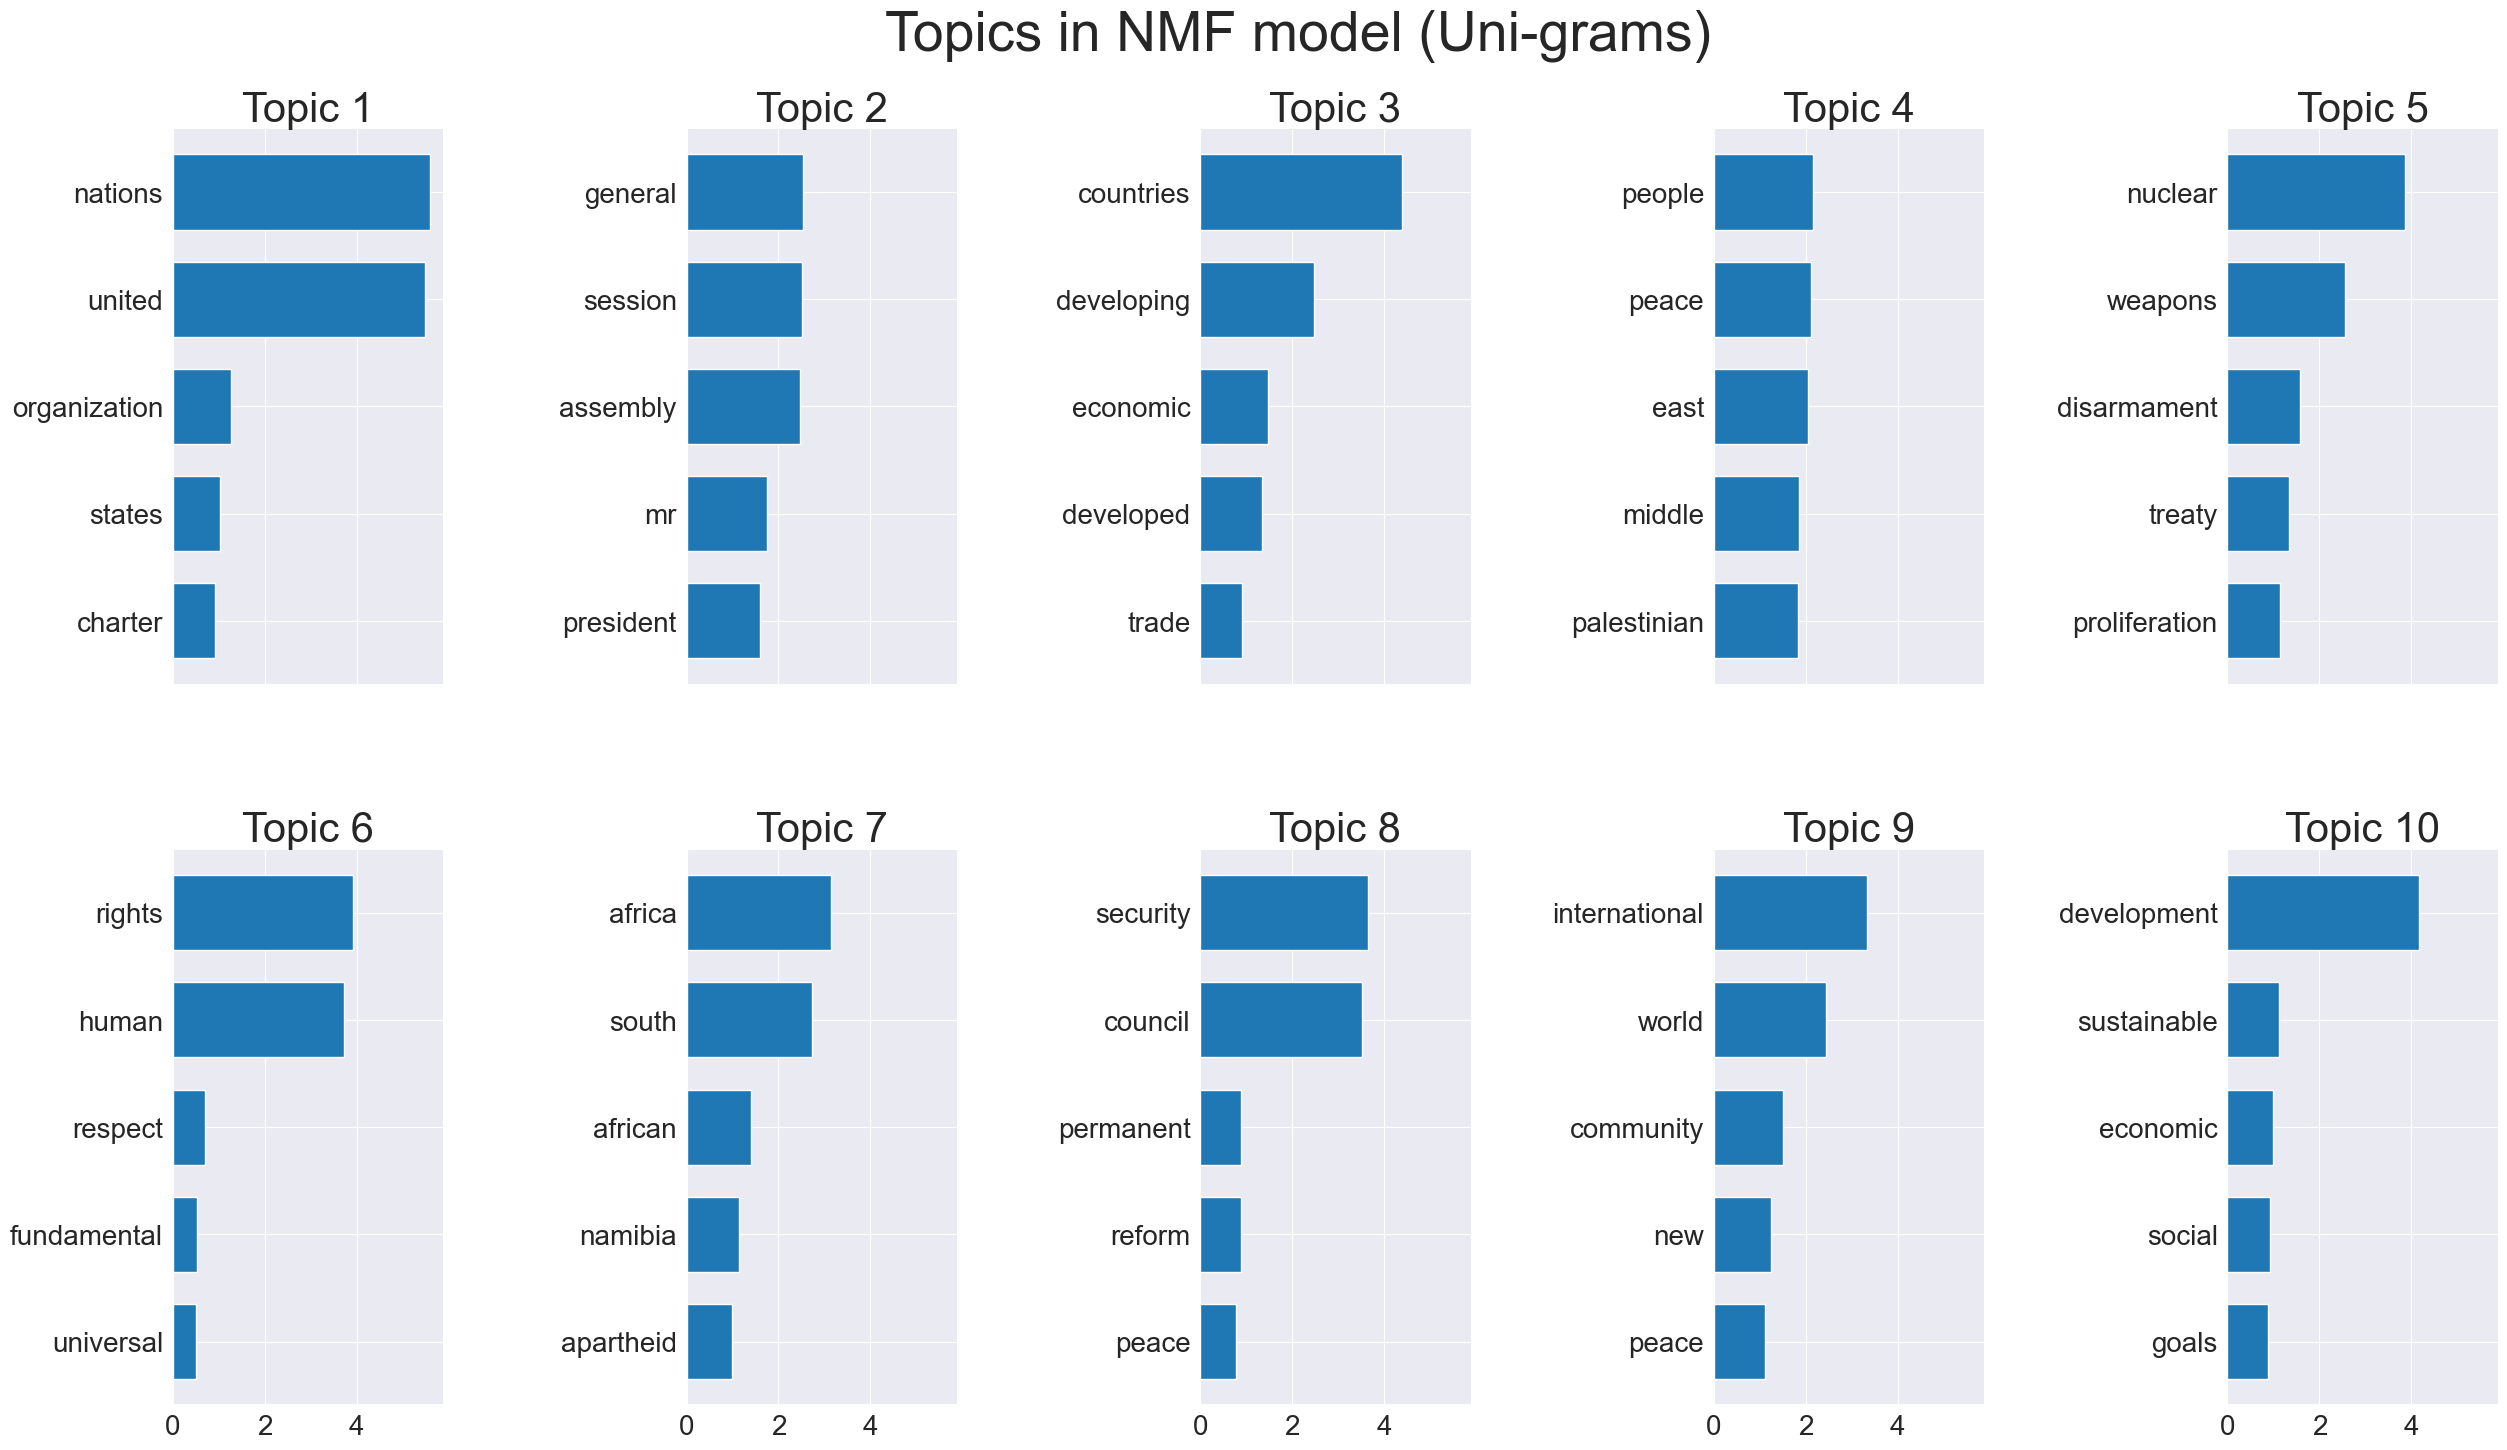

In [65]:
plot_top_words(
    model=nmf_para_model,
    feature_names=tfidf_para_vectorizer.get_feature_names_out(),
    n_top_words=5,
    title="Topics in NMF model (Uni-grams)"
)

---

In [53]:
nmf_para_model_bigrams = NMF(n_components=10, random_state=42)
W_para_matrix_bigrams = nmf_para_model_bigrams.fit_transform(tfidf_para_vectors_bigrams)
H_para_matrix_bigrams = nmf_para_model_bigrams.components_

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [61]:
#display_topics(nmf_para_model_bigrams, tfidf_para_vectorizer_bigrams.get_feature_names())

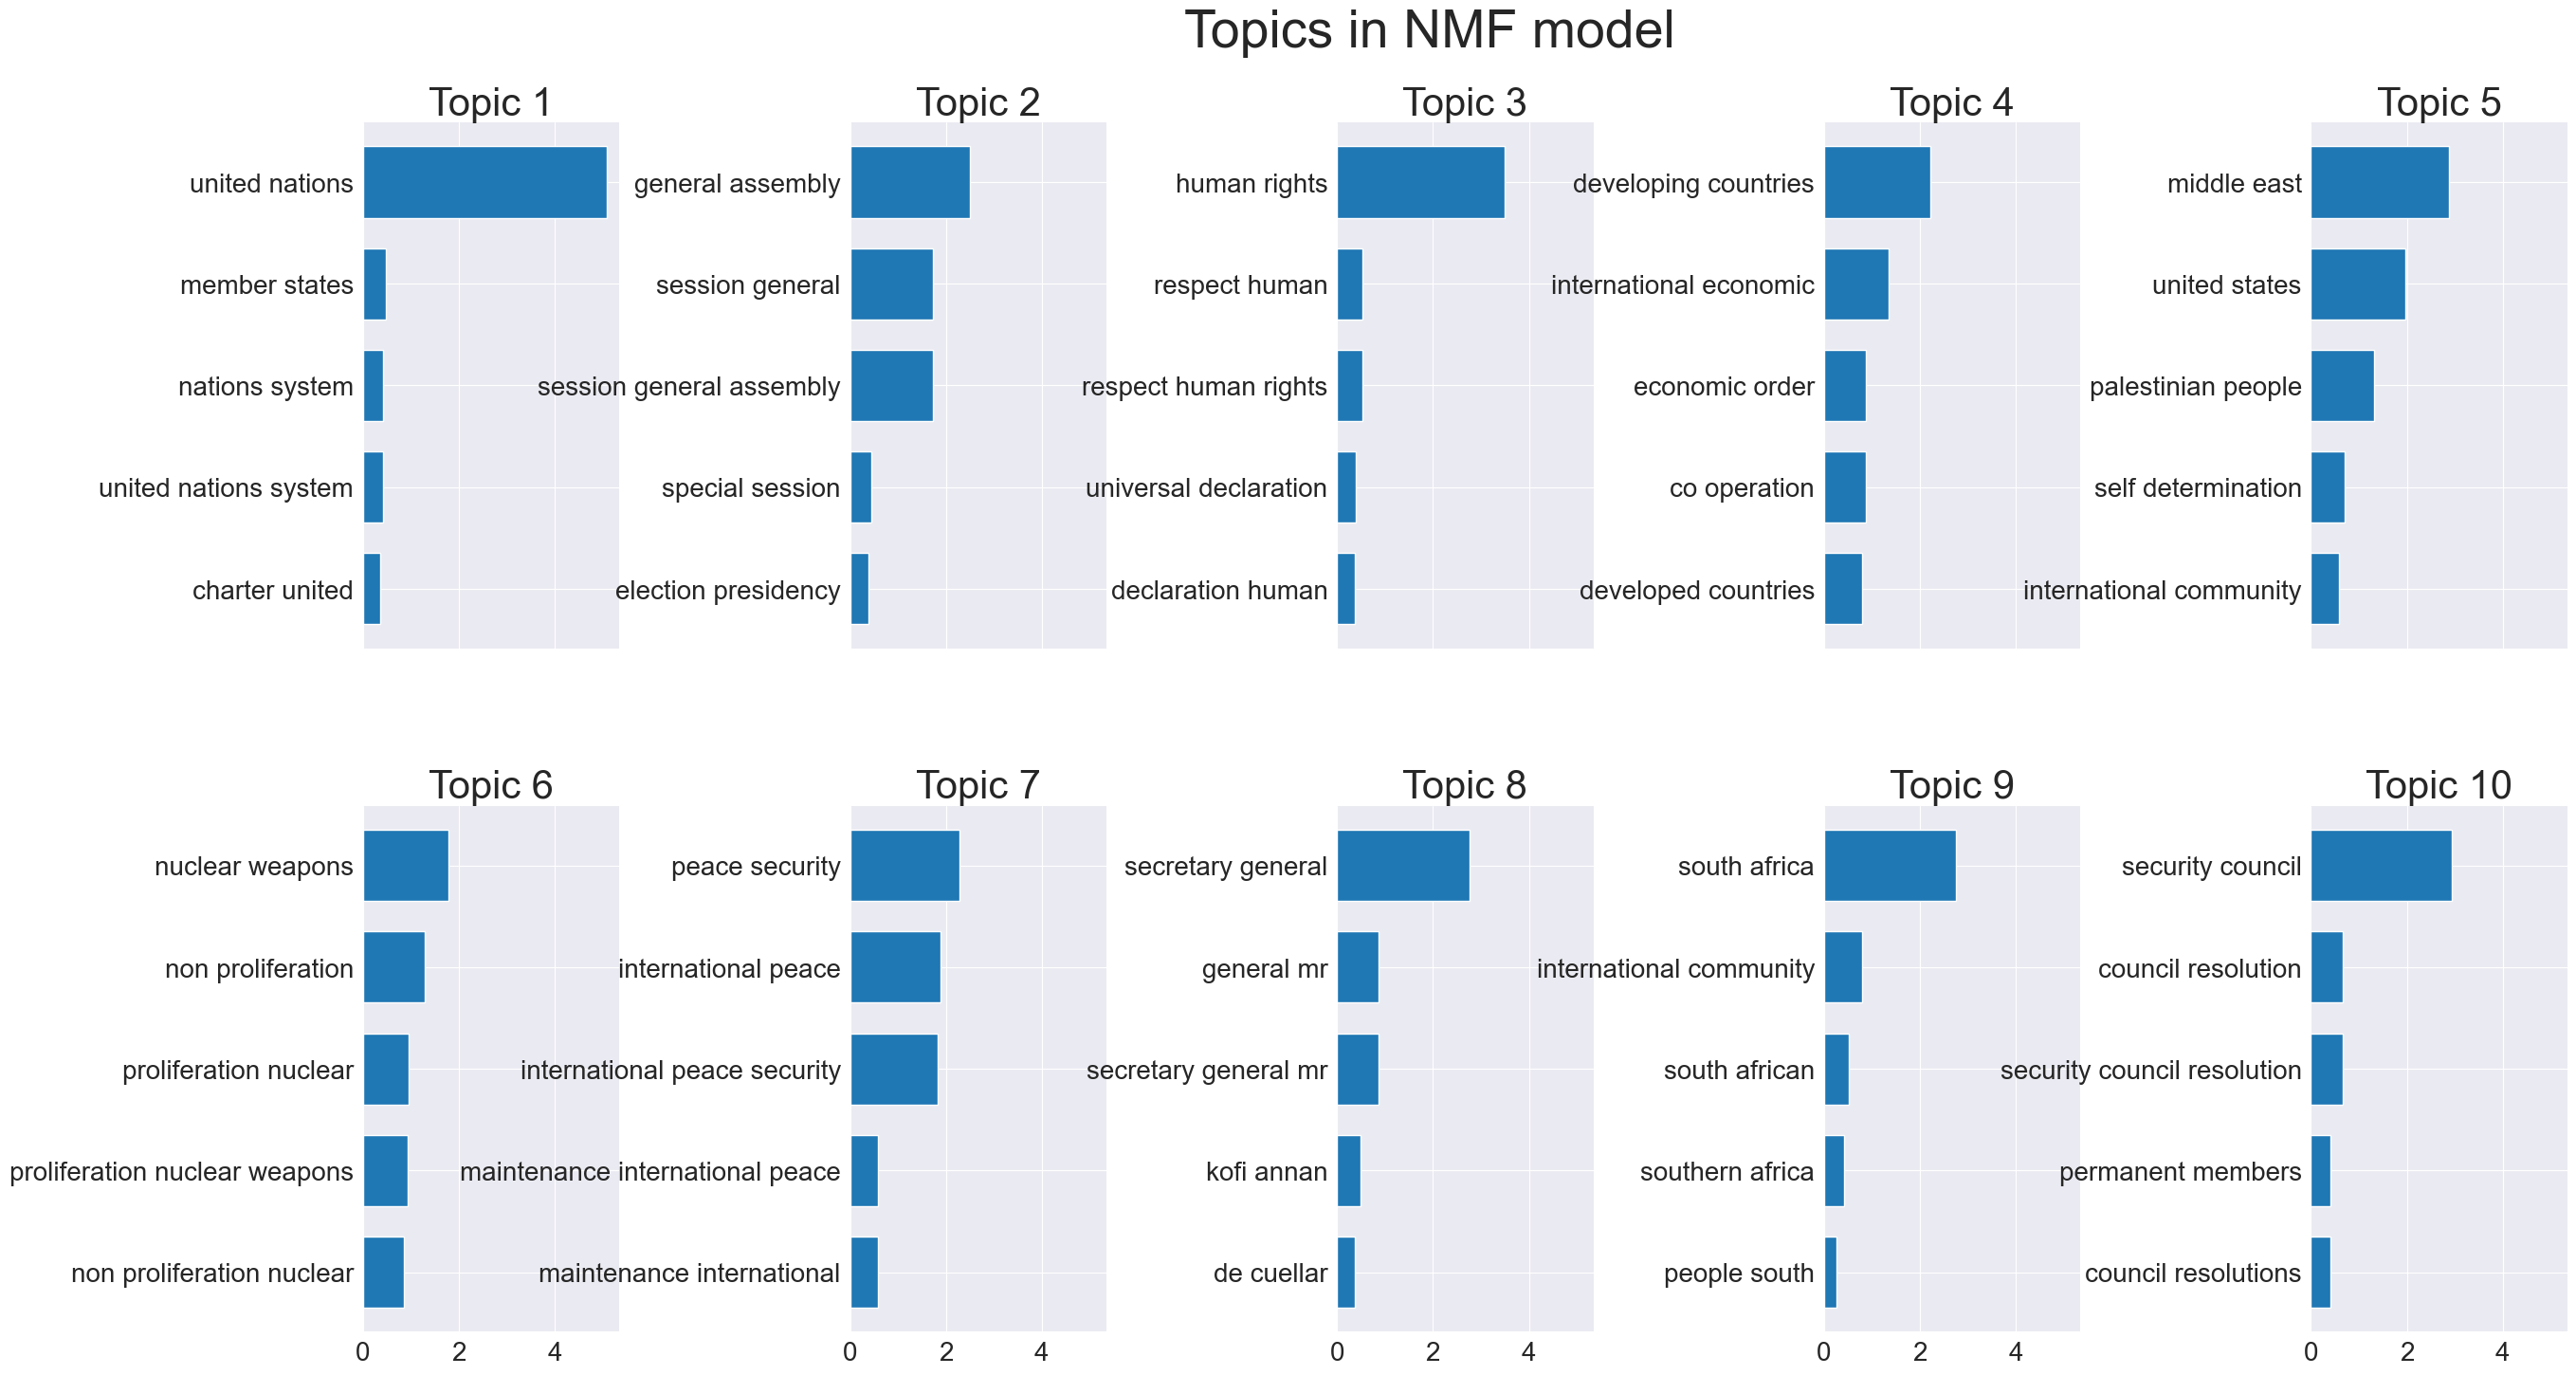

In [62]:
plot_top_words(
    model=nmf_para_model_bigrams,
    feature_names=tfidf_para_vectorizer_bigrams.get_feature_names_out(),
    n_top_words=5,
    title="Topics in NMF model (Bi-grams)"
)

https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

---

Neither the book nor the example above uses TF-IDF with LDA, but do not specify why. Both use TF-IDF with NMF and then change to CountVectorizer with LDA


https://stackoverflow.com/questions/44781047/necessary-to-apply-tf-idf-to-new-documents-in-gensim-lda-model/44789327#44789327

> LDA only needs a bag-of-word vector.



In [74]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer_bigrams = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7, ngram_range=(2,3))
count_para_vectors_bigrams = count_para_vectorizer_bigrams.fit_transform(paragraphs["text"])
count_para_vectors_bigrams.shape

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279045, 396733)

In [66]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraphs["text"])
count_para_vectors.shape

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(279045, 25162)

In [67]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

/Users/shanekercheval/repos/nlp-template/.venv/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


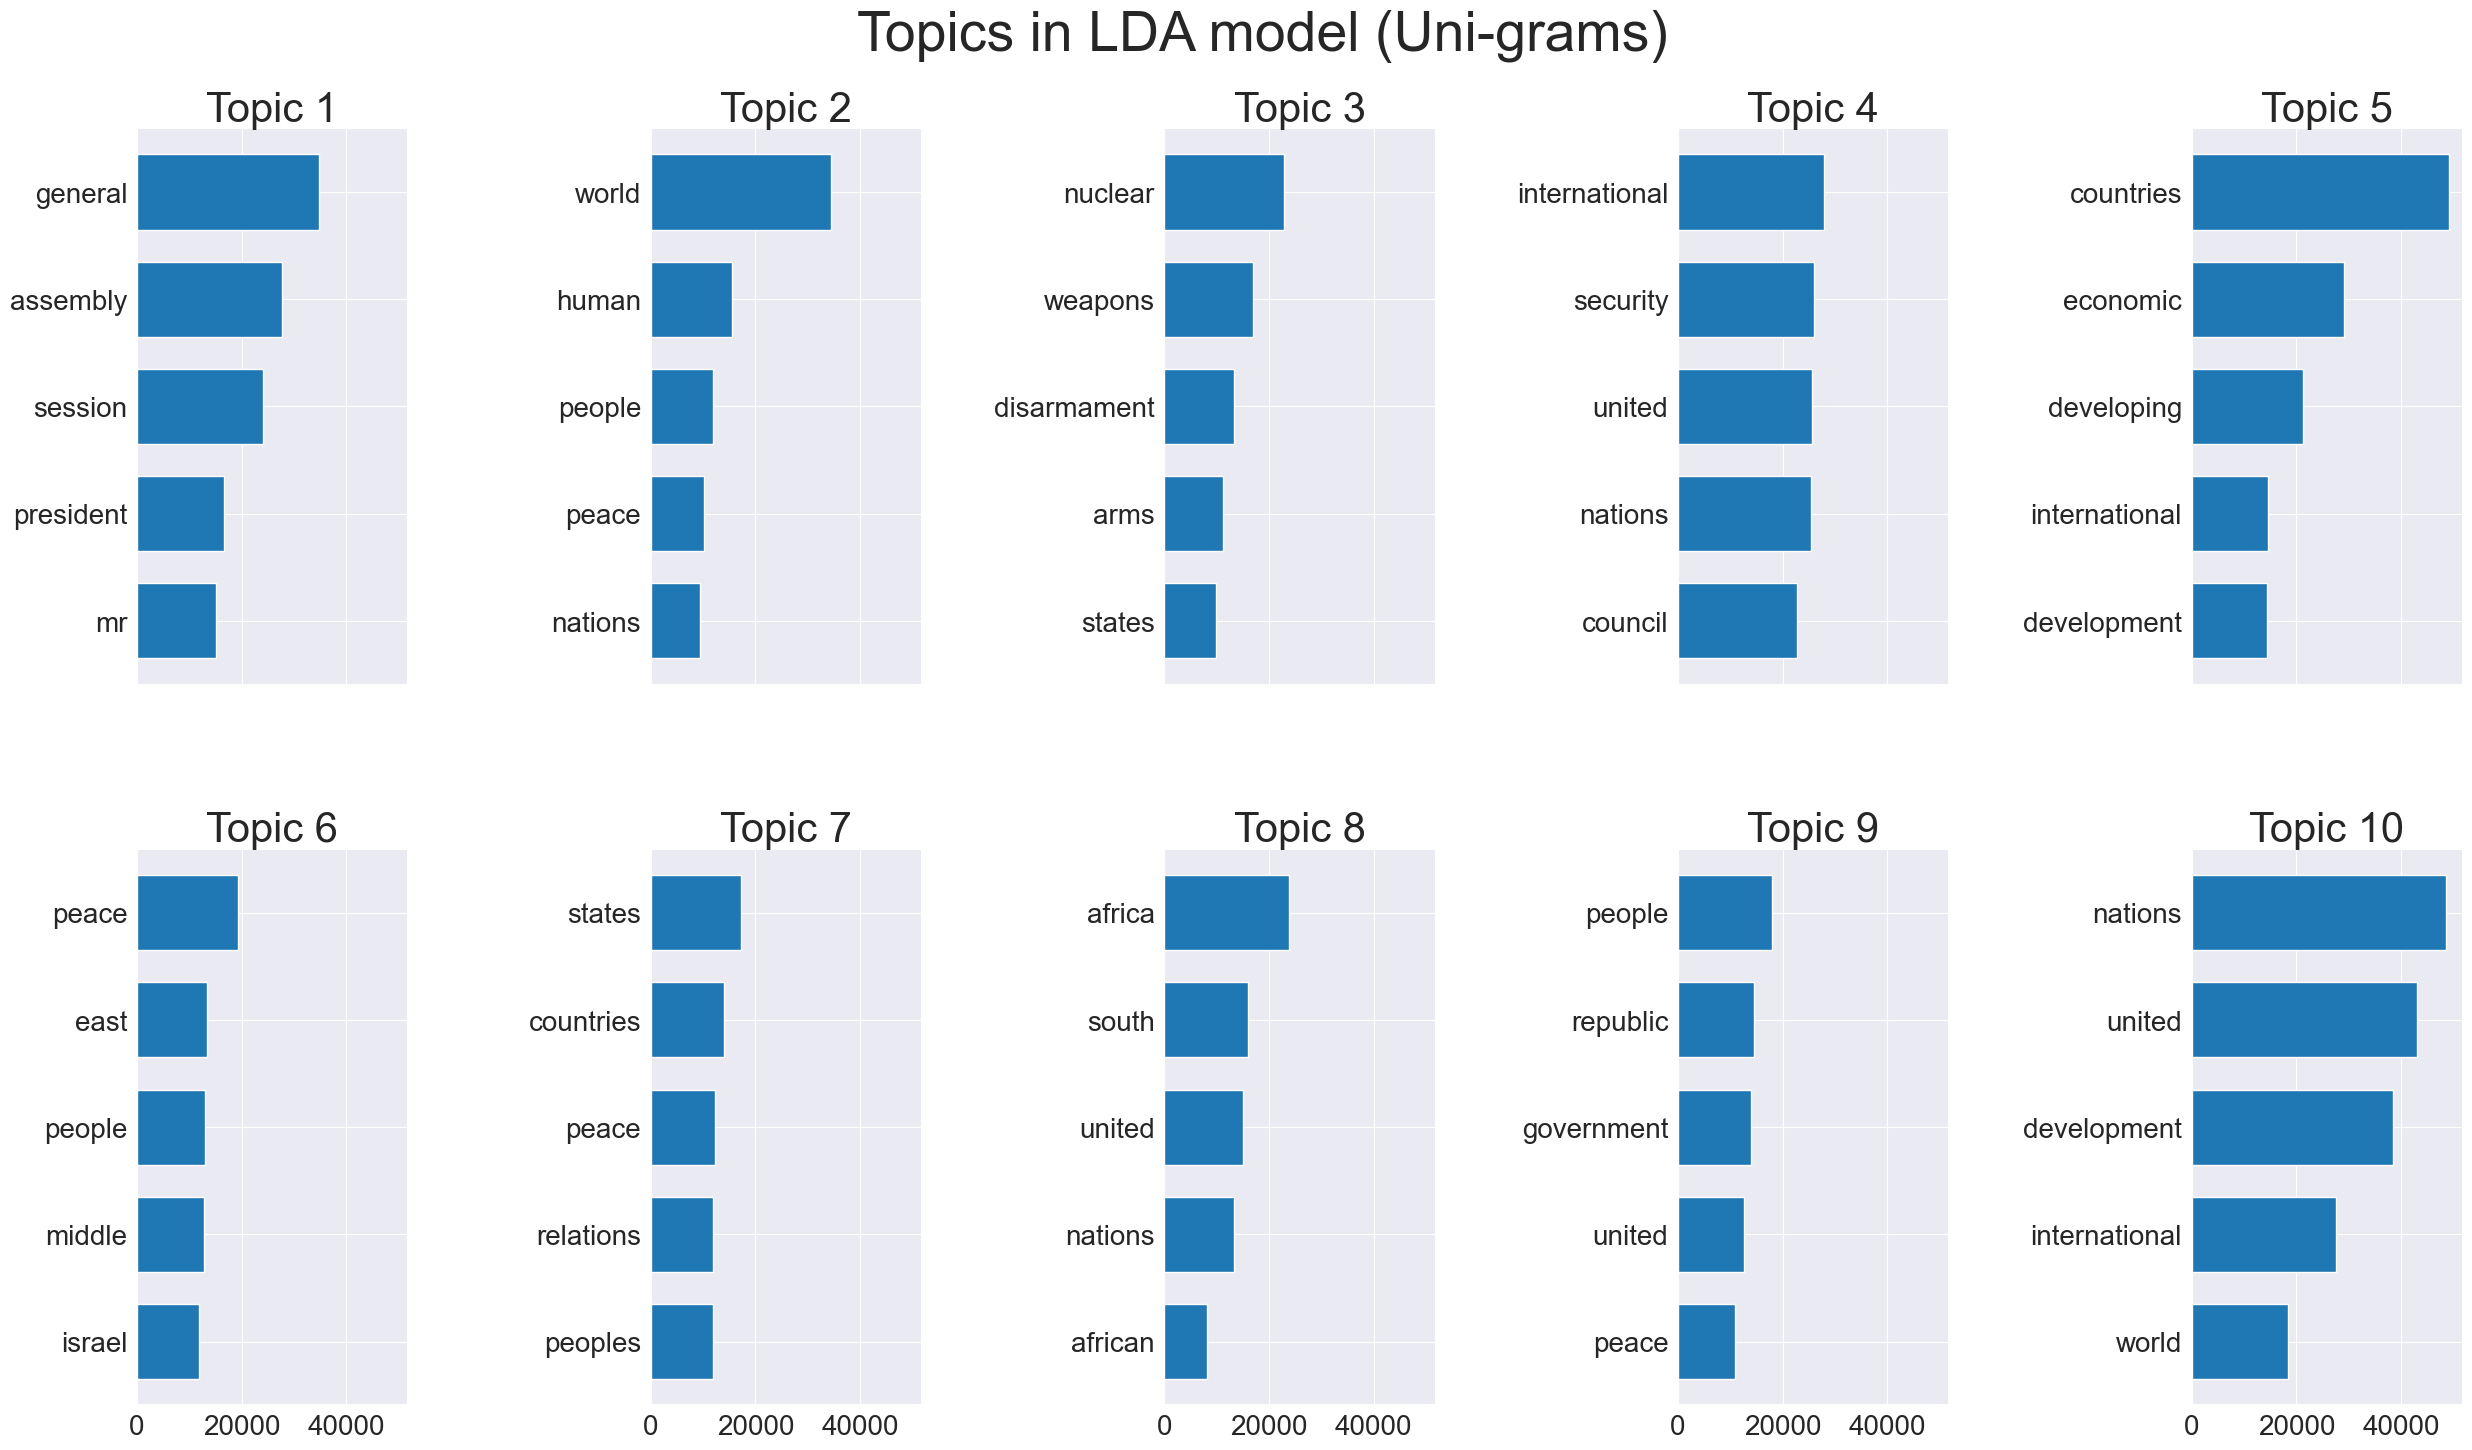

In [71]:
plot_top_words(
    model=lda_para_model,
    feature_names=count_para_vectorizer.get_feature_names_out(),
    n_top_words=5,
    title="Topics in LDA model (Uni-grams)"
)

In [68]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([ 9.14716924, 13.03694125,  7.012396  , 11.32457192,  9.2946125 ,
        8.86826234,  8.94118744,  7.10875204,  9.61481304, 15.65129423])

In [75]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model_bigrams = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix_bigrams = lda_para_model_bigrams.fit_transform(count_para_vectors_bigrams)
H_lda_para_matrix_bigrams = lda_para_model_bigrams.components_

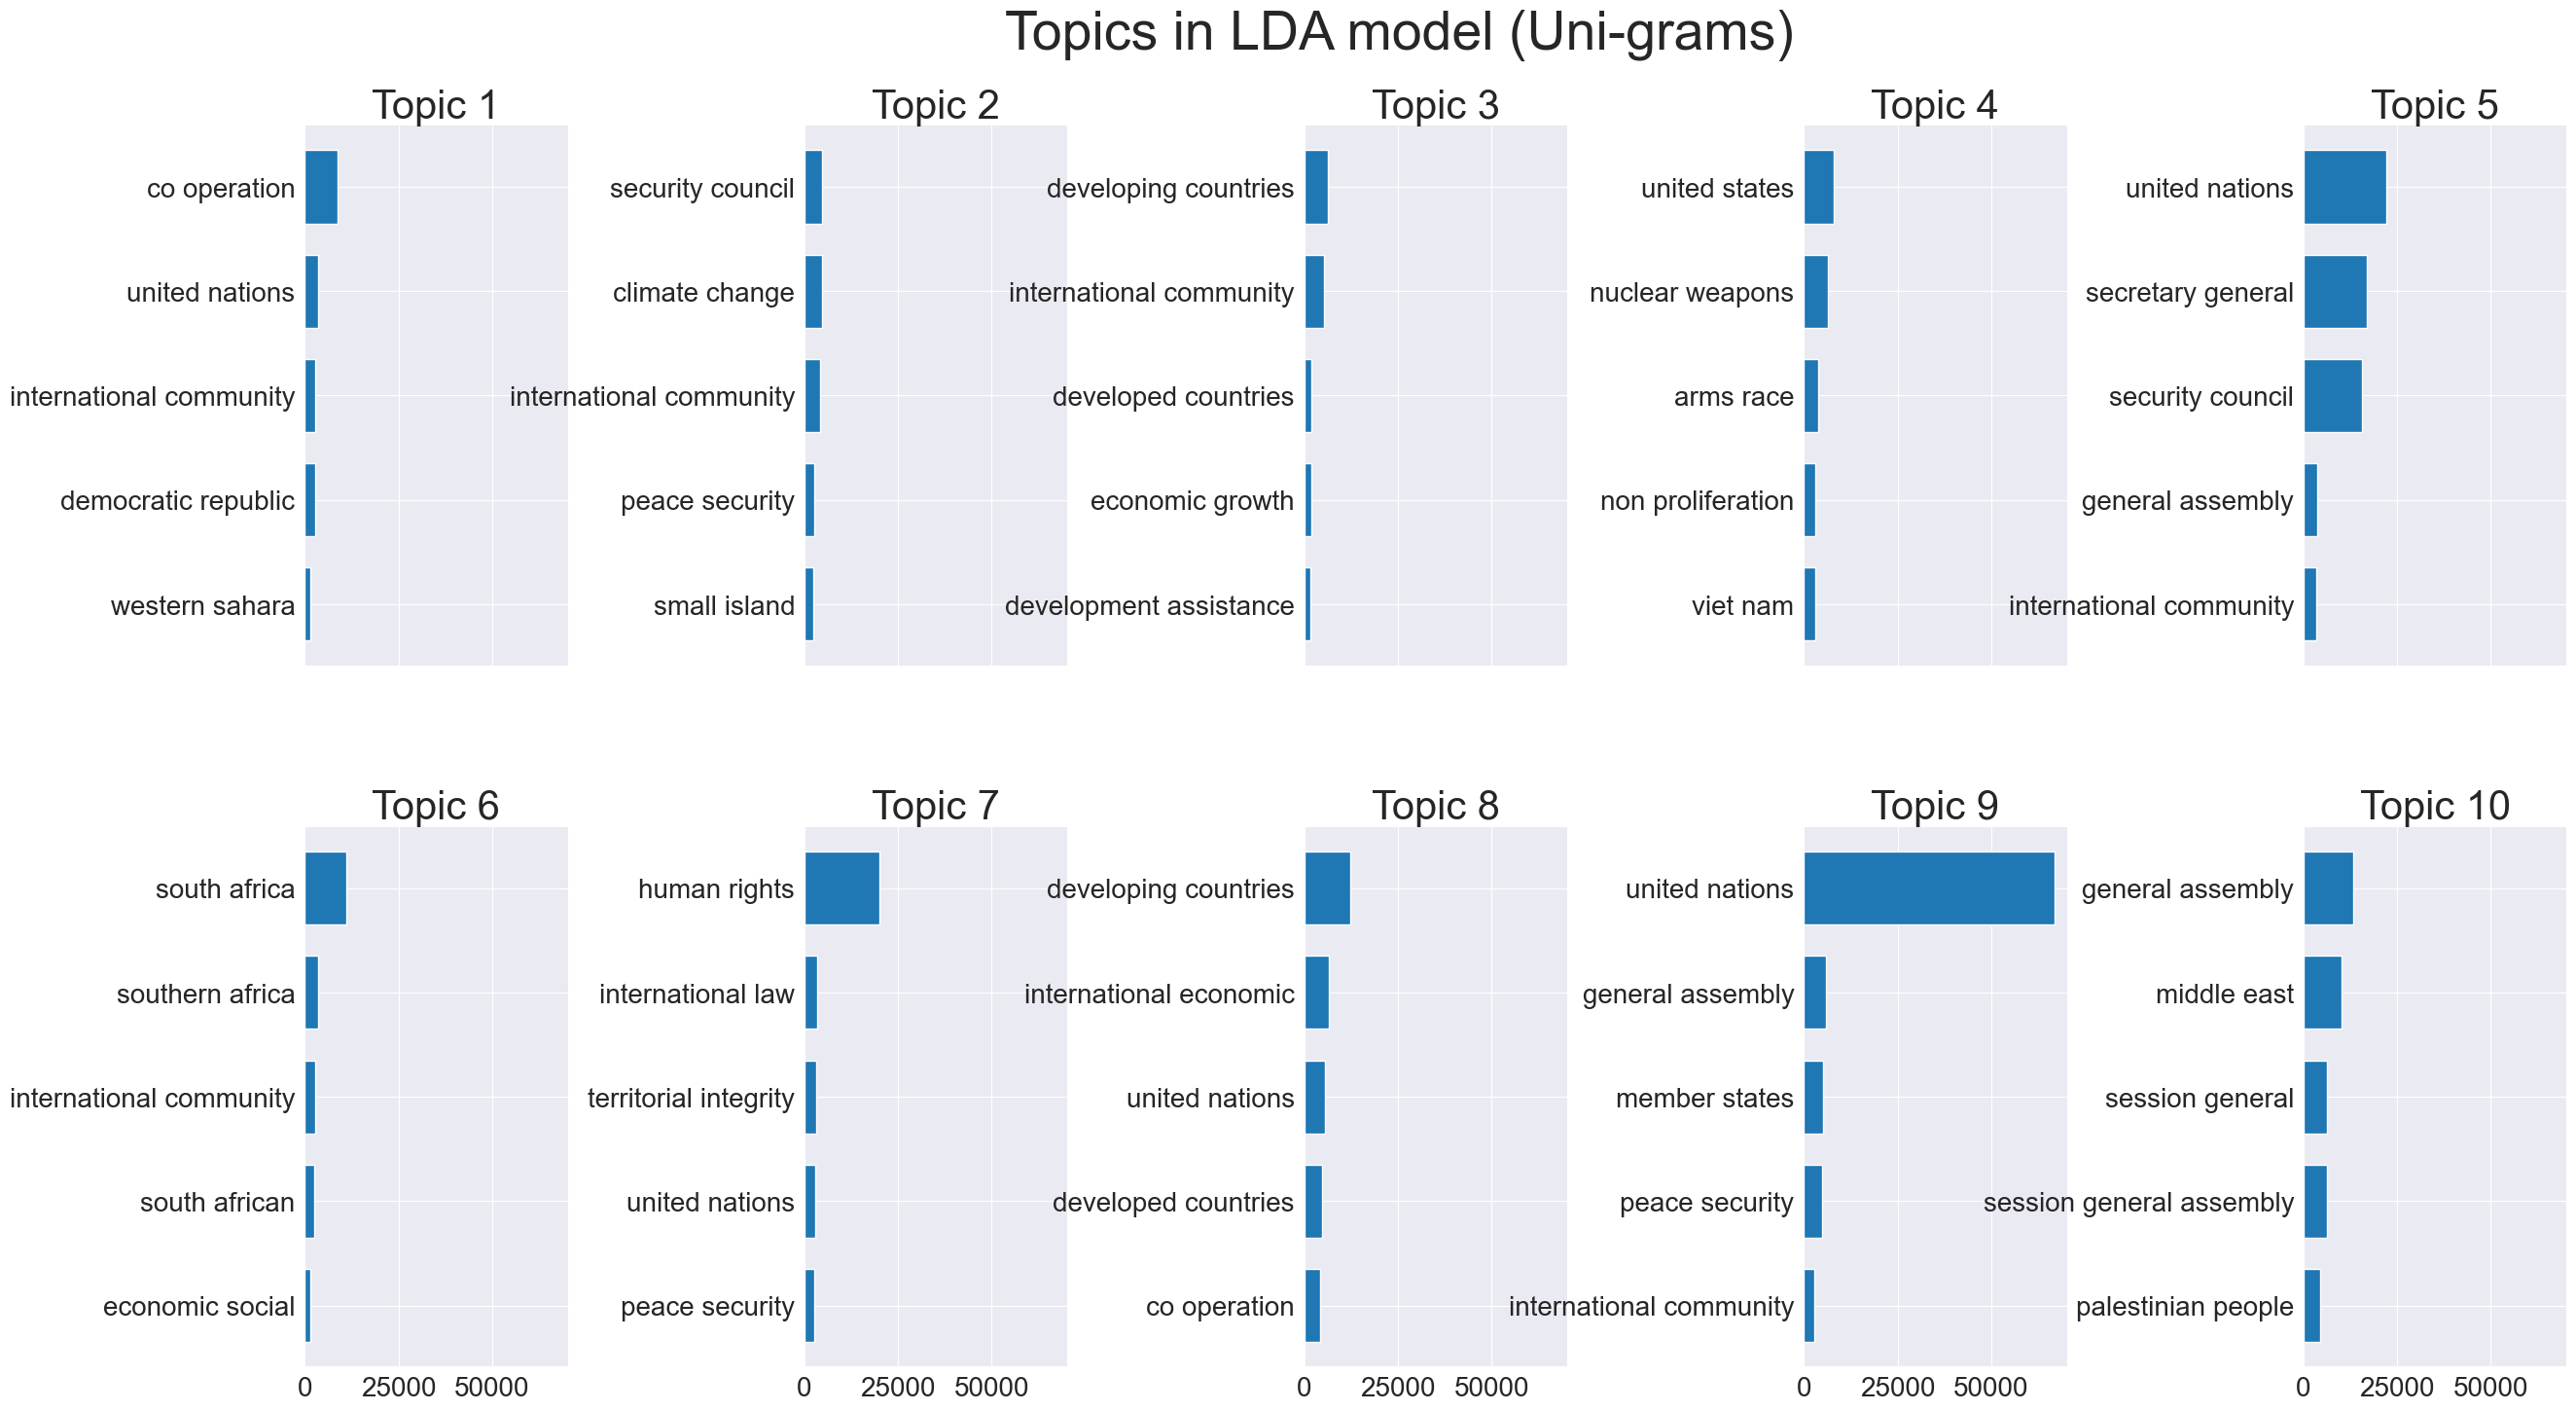

In [76]:
plot_top_words(
    model=lda_para_model_bigrams,
    feature_names=count_para_vectorizer_bigrams.get_feature_names_out(),
    n_top_words=5,
    title="Topics in LDA model (Bi-grams)"
)

In [81]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False)
#pyLDAvis.display(lda_display)
pyLDAvis.save_html(lda_display, 'docs/models/lda.html')